In [3]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import datetime as dt
from scipy import integrate
from sklearn import mixture
import csv

One of the important aspects to consider in commercial land development, especially for residential structures, is the groundwater table. If the groundwater level is falling in an area, it may indicate diminishing local availability of water resources and also potential for land collapse. Decreasing groundwater levels in coastal areas may also result in sea water intrusion into the groundwater, such that the groundwater becomes saline and not usable for consumption.
In this section, I use data from groundwater gauges from US Geological Survey (USGS) to find temporal trends in groundwater levels for a period beginning on Jan. 1, 2011. The goal is to identify areas where groundwater levels are falling, which may be problematic for land development.

In [20]:
#Load groundwater level data from 01/01/2011 to 09/30/2021
#First read in the .txt file
# read tab-delimited file
with open('gw.txt','r') as fin:
    cr = csv.reader(fin, delimiter='\t')
    filecontents = [line for line in cr]
#Now only keep lines with actual measurements/data
data=[]
for i in range(len(filecontents)):
    if filecontents[i][0]=='USGS':
        data.append([float(filecontents[i][1]),
                     filecontents[i][2],filecontents[i][3]])
#Put data into a dataframe        
gw_df = pd.DataFrame(data,
                         columns =["Site","Date","Water_Level(m)"])
gw_df["Water_Level(m)"]=pd.to_numeric(gw_df["Water_Level(m)"],'coerce')
#Split the date into month, day, year components:
month=np.zeros((len(gw_df),))
day=np.zeros((len(gw_df),))
year=np.zeros((len(gw_df),))
for i in range(len(gw_df)):
    b=re.findall(r'\d+',gw_df["Date"][i].split()[0])
    month[i]=b[0]
    day[i]=b[1]
    year[i]=b[2]
gw_df["Month"]=month
gw_df["Day"]=day
gw_df["Year"]=year

In [21]:
#Now group all groundwater level data by site
#First extract site numbers:
gf_site_nums=gw_df["Site"].unique()
for i in range(len(gf_site_nums)):
    gf_site_nums[i]=float(gf_site_nums[i])
#Now group by site number
gw_site_groups=gw_df.groupby([pd.cut(gw_df["Site"],gf_site_nums)]).groups #dict object
gw_group_inds=[gw_site_groups[key] for key in gw_site_groups.keys()]

In [22]:
#Function to interpolate missing timeseries data
def pad(data):
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    if len(good_data)!=0:
        interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
        data[bad_indexes] = interpolated
    return data

In [25]:
#Now for each site, find temporal trends of groundwater level
from scipy import stats
from statsmodels.tsa.seasonal import STL
gw_trend=[]
for inds in gw_group_inds: 
    d1=gw_df.loc[inds].copy()
        #Only consider locations where data is as recent as at least 2015
    if (max(d1["Year"])>=2015):
        #Fill in missing date
        gwpdm = pd.Series(pad(d1["Water_Level(m)"].to_numpy()),
                            index=pd.to_datetime(d1["Date"]), name = 'GW_WL')
        #Calculate linear temporal trend after first extracting seasonal fluctuations
        stl = STL(gwpdm)
        res = stl.fit()
        [s,_,_,_,_]=stats.linregress(np.arange(0,len(res.trend.to_numpy()),1),res.trend.to_numpy())
        #Store site number, groundwater level trend (in m/yr), beginning of timeseries and end of timeseries dates
        gw_trend.append([d1['Site'].to_numpy()[0],s*365.,min(pd.to_datetime(d1["Date"])),max(pd.to_datetime(d1["Date"]))])
            
#Put groundwater trend data into a dataframe        
gw_trend_df = pd.DataFrame(gw_trend,
                         columns =["Site","Water_Level_Trend(m/yr)","BeginDate","EndDate"])

In [26]:
#Now load site information for the groundwater measurement sites (i.e., latitude and longitude)
#First read in the .txt file
# read tab-delimited file
with open('gw_loc.txt','r') as fin:
    cr = csv.reader(fin, delimiter='\t')
    filecontents = [line for line in cr]
#Now only keep lines with actual measurements/data
data_loc=[]
for i in range(len(filecontents)):
    if filecontents[i][0]=='USGS':
        data_loc.append([float(filecontents[i][1]),
                     filecontents[i][4],filecontents[i][5]])
gw_loc_df = pd.DataFrame(data_loc,
                         columns =["Site","Latitude","Longitude"])

In [27]:
#Now merge dataframes with groundwater trend and groundwater site information so that we can visualize them on a map
gw_tot_df = pd.merge(gw_trend_df,gw_loc_df , on="Site")
gw_tot_df["Latitude"]=pd.to_numeric(gw_tot_df["Latitude"],'coerce')
gw_tot_df["Longitude"]=pd.to_numeric(gw_tot_df["Longitude"],'coerce')
gw_tot_df.to_pickle('GW_trends.pkl')

Text(0.5, 1.0, 'Groundwater Level Trend (m/yr)')

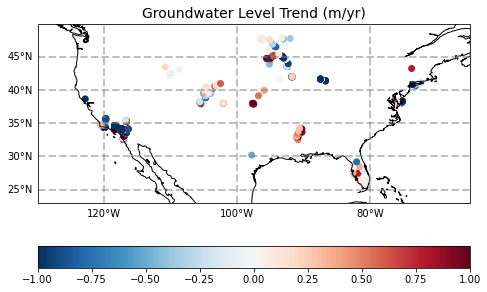

In [47]:
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax.coastlines()
h=ax.scatter(gw_tot_df['Longitude'].to_numpy(),gw_tot_df['Latitude'].to_numpy(),
             c=gw_tot_df['Water_Level_Trend(m/yr)'].to_numpy(),vmin=-1,vmax=1,
             cmap='RdBu_r',transform=ccrs.PlateCarree())
plt.colorbar(h,ax=ax,location='bottom')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-120,-100,-80,-60])
gl.ylocator = mticker.FixedLocator([25,30,35,40,45,50])
gl.xlabels_top = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title('Groundwater Level Trend (m/yr)',fontsize=14)

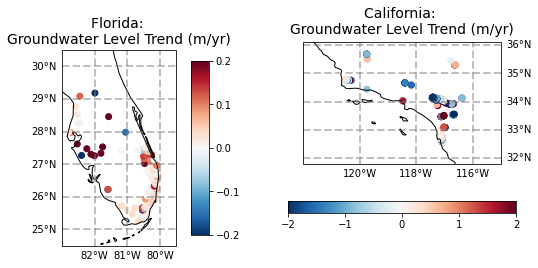

In [133]:
#Zoom in around Florida and California
fig = plt.figure()
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

#ax1.set_extent([-130, -65, 10, 45], ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
h=ax1.scatter(gw_tot_df['Longitude'].to_numpy(),gw_tot_df['Latitude'].to_numpy(),
             c=gw_tot_df['Water_Level_Trend(m/yr)'].to_numpy(),vmin=-0.2,vmax=0.2,
            cmap='RdBu_r',transform=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.right_labels = False
ax1.set_xlim([-83,-79.5])
ax1.set_ylim([24.5,30.5])
gl.xlocator = mticker.FixedLocator([-82,-81,-80])
ax1.set_title('Florida: \nGroundwater Level Trend (m/yr)',fontsize=14)
cb1=plt.colorbar(h,ax=ax1,pad=0.1,aspect=10,shrink=0.8,ticks=[-0.2,-0.1,0,0.1,0.2])
box1 = ax1.get_position()


#ax2.set_extent([-130, -65, 10, 45], ccrs.PlateCarree())
ax2.coastlines(resolution='50m')
h=ax2.scatter(gw_tot_df['Longitude'].to_numpy(),gw_tot_df['Latitude'].to_numpy(),
             c=gw_tot_df['Water_Level_Trend(m/yr)'].to_numpy(),vmin=-2,vmax=2,
            cmap='RdBu_r',transform=ccrs.PlateCarree())
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-120,-118,-116])
gl.ylocator = mticker.FixedLocator([32,33,34,35,36])
gl.xlabels_top = False
gl.left_labels = False
ax2.set_xlim([-122,-115])
ax2.set_ylim([31.8,36.1])
ax2.set_title('California: \nGroundwater Level Trend (m/yr)',fontsize=14)
pos1 = ax2.get_position() # get the original position 
pos2 = [pos1.x0+0.1, pos1.y0-0.12 ,  pos1.width*1.5, pos1.height*2] 
ax2.set_position(pos2) # set a new position
plt.colorbar(h,ax=[ax2],pad=0.2,location='bottom')

From the plot above, we can see that in most parts of Florida, including coastal areas, groundwater level is actually increasing, whereas in California, groundwater level is decreasing in many areas.

Another desirable aspect for residential land development is green space. Presence of green spaces and forest cover is both visually attractive and can help local air quality, in contrast with industrial land cover (e.g., asphalt) or sand cover (e.g., arid areas). In this section, I will look at temporal changes in the vegetation index obtained from satellite imagery taken by MODIS (instrument mounted on Terra and Aqua satellites operated by NASA).

In [1]:
from pyhdf.SD import SD, SDC
import glob
import numpy as np

#latitude and longitude at 0.5 degree resolution
lat=np.linspace(90,-90,360)
lon=np.arange(-180,180,0.5)

filelist = glob.glob('MOD13C*') #collect all MODIS files (monthly) from 09/01/2017 to 08/30/2021
VI_US = np.zeros((52,130,len(filelist))) #will only choose points over continental U.S.
for i in range(len(filelist)):
    filename = filelist[i]
    hdf = SD(filename, SDC.READ)
    EVI = hdf.select('CMG 0.05 Deg Monthly EVI')[:,:]
    EVI=EVI[0::10,0::10]
    VI_US[:,:,i]=EVI[80:132,100:230]

In [5]:
#Now for each grid point, find temporal trends of vegetation index
from scipy import stats
from statsmodels.tsa.seasonal import STL
VI_trend=np.zeros((52,130))
for i in range(52):
    for j in range(130):
        vipdm = pd.Series(VI_US[i,j,0:48], index=pd.date_range('9-1-2017', periods=48, freq='M'), name = 'VI')
        stl = STL(vipdm)
        res = stl.fit()
        [s,_,_,_,_]=stats.linregress(np.arange(0,len(res.trend.to_numpy()),1),res.trend.to_numpy())
        VI_trend[i,j]=s*12. #returns change in vegetation index on annual basis

In [16]:
np.savez('Vegetation_analysis.npz',VI_US=VI_US,VI_trend=VI_trend,lat=lat[80:132],lon=lon[100:230])

Text(0.5, 1.0, 'Annual Vegetation Index Trend')

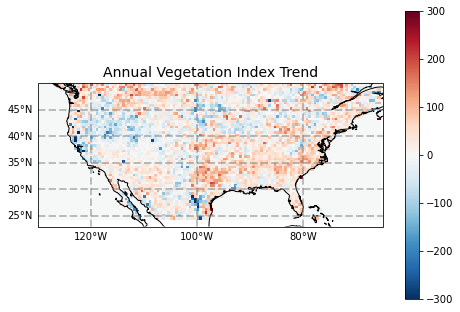

In [15]:
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax.coastlines()
h=ax.pcolor(lon[100:230],lat[80:132],
             VI_trend,vmin=-0.3e3,vmax=0.3e3, 
             cmap='RdBu_r',transform=ccrs.PlateCarree())
plt.colorbar(h,ax=ax,location='right')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-120,-100,-80,-60])
gl.ylocator = mticker.FixedLocator([25,30,35,40,45,50])
gl.xlabels_top = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title('Annual Vegetation Index Trend',fontsize=14)

Local air quality is another concern for residential land development - it would be difficult to sell mid- to up-scale residences in areas with poor air quality. One of the important pollutants that determines air quality is nitrogen dioxide, which is measured by TROPOMI instrument on Sentinel-5 (satellite operated by European Space Agency). Its output is in swaths and data is reported over 7km x 3.5km pixels. Because of the large volume of data, I will only show one time step taken on 9/25/2021 (combined from 3 swaths that approximately cover the U.S.) here, though analysis in the actual capstone project will be performed over the entire available dataset, once it has been fully downloaded.

In [17]:
from netCDF4 import Dataset 
#First import swath #1
nc_fid = Dataset('NO2_test1.nc', 'r')
product=nc_fid.groups["PRODUCT"]
nc_vars = [var for var in product.variables]  # list of all variables stored in the NetCDF file
#for var in nc_vars:
#        print('\tName:', var)
#        print("\t\tdimensions:", product.variables[var].dimensions)
#        print("\t\tsize:", product.variables[var].size)

lat_1 = product.variables["latitude"][0,:,:]
lon_1=product.variables["longitude"][0,:,:]
NO2_1 = product.variables["nitrogendioxide_tropospheric_column"][0,:,:]
mask1 = np.ma.getmaskarray(NO2_1)
lat_1 = np.ma.array(lat_1,mask=mask1)
lon_1 = np.ma.array(lon_1,mask=mask1)

#Create dataframe with latitude, longtitude and NO2 concentration values 
NO2_df1 = pd.DataFrame({"Lat":lat_1.compressed(),"Lon":lon_1.compressed(),
                       "NO2":NO2_1.compressed()},index=range(len(NO2_1.compressed())))
#Crop data frame to go from longitude 65-130 degrees West and latitude 23-50 degrees North (approx. U.S.)
NO2_df1.drop(NO2_df1[NO2_df1['Lon'] >-65].index, inplace=True)
NO2_df1.drop(NO2_df1[NO2_df1['Lon'] <-130].index, inplace=True)
NO2_df1.drop(NO2_df1[NO2_df1['Lat'] >50].index, inplace=True)
NO2_df1.drop(NO2_df1[NO2_df1['Lat'] <23].index, inplace=True)
NO2_df1.drop(NO2_df1[NO2_df1['NO2'] <0].index, inplace=True)


#Now import swath #2
nc_fid = Dataset('NO2_test2.nc', 'r')
product=nc_fid.groups["PRODUCT"]
lat_2 = product.variables["latitude"][0,:,:]
lon_2=product.variables["longitude"][0,:,:]
NO2_2 = product.variables["nitrogendioxide_tropospheric_column"][0,:,:]
mask2 = np.ma.getmaskarray(NO2_2)
lat_2 = np.ma.array(lat_2,mask=mask2)
lon_2 = np.ma.array(lon_2,mask=mask2)
#Create dataframe with latitude, longtitude and NO2 concentration values 
NO2_df2 = pd.DataFrame({"Lat":lat_2.compressed(),"Lon":lon_2.compressed(),
                       "NO2":NO2_2.compressed()},index=range(len(NO2_2.compressed())))
#Crop data frame to go from longitude 65-130 degrees West and latitude 23-50 degrees North (approx. U.S.)
NO2_df2.drop(NO2_df2[NO2_df2['Lon'] >-65].index, inplace=True)
NO2_df2.drop(NO2_df2[NO2_df2['Lon'] <-130].index, inplace=True)
NO2_df2.drop(NO2_df2[NO2_df2['Lat'] >50].index, inplace=True)
NO2_df2.drop(NO2_df2[NO2_df2['Lat'] <23].index, inplace=True)
NO2_df2.drop(NO2_df2[NO2_df2['NO2'] <0].index, inplace=True)

#Now import swath #3
nc_fid = Dataset('NO2_test3.nc', 'r')
product=nc_fid.groups["PRODUCT"]
lat_3 = product.variables["latitude"][0,:,:]
lon_3=product.variables["longitude"][0,:,:]
NO2_3 = product.variables["nitrogendioxide_tropospheric_column"][0,:,:]
mask3 = np.ma.getmaskarray(NO2_3)
lat_3 = np.ma.array(lat_3,mask=mask3)
lon_3 = np.ma.array(lon_3,mask=mask3)
#Create dataframe with latitude, longtitude and NO2 concentration values 
NO2_df3 = pd.DataFrame({"Lat":lat_3.compressed(),"Lon":lon_3.compressed(),
                       "NO2":NO2_3.compressed()},index=range(len(NO2_3.compressed())))
#Crop data frame to go from longitude 65-130 degrees West and latitude 23-50 degrees North (approx. U.S.)
NO2_df3.drop(NO2_df3[NO2_df3['Lon'] >-65].index, inplace=True)
NO2_df3.drop(NO2_df3[NO2_df3['Lon'] <-130].index, inplace=True)
NO2_df3.drop(NO2_df3[NO2_df3['Lat'] >50].index, inplace=True)
NO2_df3.drop(NO2_df3[NO2_df3['Lat'] <23].index, inplace=True)
NO2_df3.drop(NO2_df3[NO2_df3['NO2'] <0].index, inplace=True)

Text(0.5, 0.98, '$NO_2$ concentrations')

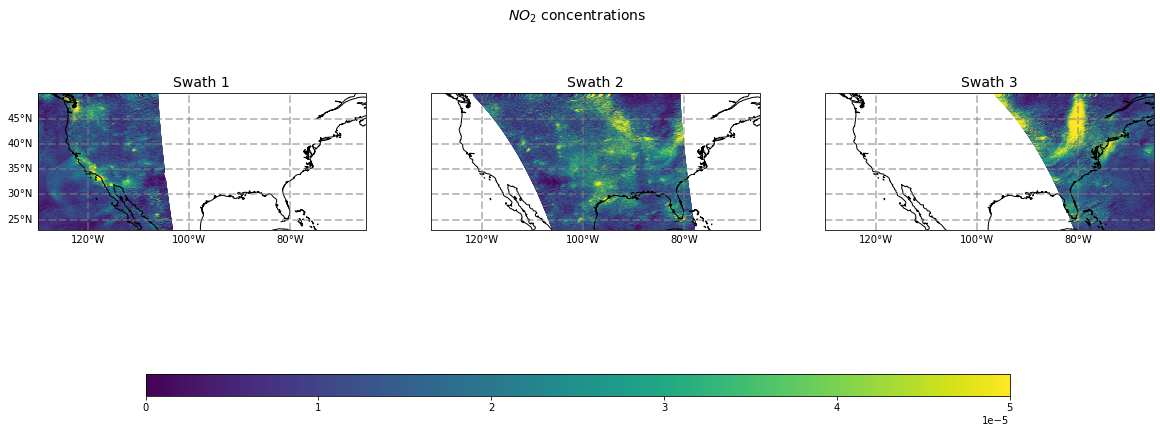

In [291]:
#Now visualize data from swaths 1 and 2 overlaid over map of the U.S.
fig = plt.figure()
fig.set_size_inches(20,6)
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())

ax1.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
h=ax1.scatter(NO2_df1['Lon'].to_numpy(),NO2_df1['Lat'].to_numpy(),
             c=NO2_df1['NO2'].to_numpy(),vmin=0,vmax=5e-5,
             cmap='viridis',transform=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-120,-100,-80,-60])
gl.ylocator = mticker.FixedLocator([25,30,35,40,45,50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False
ax1.set_title('Swath 1',fontsize=14)
pos1 = ax1.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0+0.12 ,  pos1.width, pos1.height] 
ax1.set_position(pos2) # set a new position

ax2.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax2.coastlines(resolution='50m')
h=ax2.scatter(NO2_df2['Lon'].to_numpy(),NO2_df2['Lat'].to_numpy(),
             c=NO2_df2['NO2'].to_numpy(),vmin=0,vmax=5e-5,
             cmap='viridis',transform=ccrs.PlateCarree())
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-120,-100,-80,-60])
gl.ylocator = mticker.FixedLocator([25,30,35,40,45,50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax2.set_title('Swath 2',fontsize=14)
pos1 = ax2.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0+0.12 ,  pos1.width, pos1.height] 
ax2.set_position(pos2) # set a new position

ax3.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax3.coastlines(resolution='50m')
h=ax3.scatter(NO2_df3['Lon'].to_numpy(),NO2_df3['Lat'].to_numpy(),
             c=NO2_df3['NO2'].to_numpy(),vmin=0,vmax=5e-5,
             cmap='viridis',transform=ccrs.PlateCarree())
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-120,-100,-80,-60])
gl.ylocator = mticker.FixedLocator([25,30,35,40,45,50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax3.set_title('Swath 3',fontsize=14)
pos1 = ax3.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0+0.12 ,  pos1.width, pos1.height] 
ax3.set_position(pos2) # set a new position

cbar_ax2 = fig.add_axes([0.2, 0.08, 0.6, 0.05])
clb2=fig.colorbar(h,cax=cbar_ax2,orientation='horizontal')

plt.suptitle('$NO_2$ concentrations',fontsize=14)


In [18]:
#Combine dataframes from all three swaths
NO2_df_tot = pd.concat([NO2_df1,NO2_df2,NO2_df3],ignore_index=True)

In [19]:
NO2_df_tot.to_pickle('NO2_tot_swath_ex.pkl')

C:\Users\Barbara\anaconda3\envs\tf\lib\site-packages\cartopy\mpl\gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


Text(0.5, 1.0, '$NO_2$ concentrations')

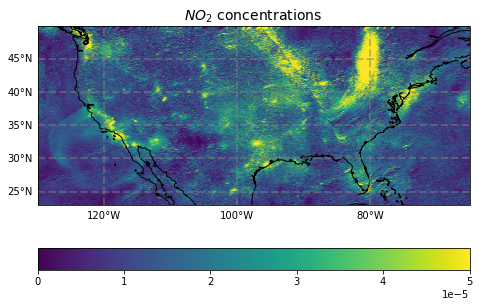

In [294]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax.coastlines()
h=ax.scatter(NO2_df_tot['Lon'].to_numpy(),NO2_df_tot['Lat'].to_numpy(),
             c=NO2_df_tot['NO2'].to_numpy(),vmin=0,vmax=5e-5,
             cmap='viridis',transform=ccrs.PlateCarree())
plt.colorbar(h,ax=ax,location='bottom')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-120,-100,-80,-60])
gl.ylocator = mticker.FixedLocator([25,30,35,40,45,50])
gl.xlabels_top = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title('$NO_2$ concentrations',fontsize=14)